In [1]:
id_ = 'Chen_Zhang_2020_NSCLC'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'


In [2]:
# Parameters
id_ = "Lambrechts_2018_LUAD_6653"


In [3]:
import os
from pathlib import Path
import gdown

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

from ikarus import classifier, utils, data
import infercnvpy as cnv

In [4]:
def remove_by_str(x: pd.DataFrame, conts: str = 'H', keep_one: bool=True) -> pd.Series:
    """
    Filters rows in a Pandas DataFrame based on the presence of a specified 
    string in the 'chromosome' column.

    This function removes rows where the 'chromosome' column contains the specified
    string (default is 'H'). If all rows contain the specified string and `keep_one`
    is set to True, the function returns the first row of the DataFrame to ensure 
    that the result is not empty.

    Parameters:
    - x (pd.DataFrame): The DataFrame to process. Must include a 'chromosome' column.
    - conts (str, optional): The string to search for in the 'chromosome' column. 
      Rows containing this string will be removed. Defaults to 'H'.
    - keep_one (bool, optional): A flag to indicate whether to keep at least one 
      row in the resulting DataFrame, even if all rows contain the specified string.
      Defaults to True.

    Returns:
    - pd.DataFrame: A DataFrame with rows containing the specified string removed. 
      If `keep_one` is True and all rows contain the string, the first row of the 
      original DataFrame is returned.

    """
    non_conts = np.logical_not( x['chromosome'].str.contains(conts))
    if non_conts.sum() < 1 and keep_one:
        return x.iloc[0,:]
    else:
        return x.loc[non_conts, :].iloc[0,:]

In [5]:
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 26514 × 26359
    obs: 'dataset', 'sample', 'patient', 'origin', 'condition', 'platform', 'age', 'sex', 'tissue', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
from pybiomart import Server

# Connect to the Ensembl biomart server
server = Server(host='http://www.ensembl.org')

# Select the appropriate dataset (e.g., human genes)
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Prepare the query
# Replace 'your_gene_symbols' with a list of your gene symbols
query = dataset.query(attributes=['external_gene_name', 'chromosome_name', 'start_position', 'end_position'])


# join_map_mart(query, adata.var , gene_annot='gene_symbol', how='inner')


In [7]:
gene_var = pd.merge(
        pd.DataFrame({'Gene name':adata.var.index}),
        query,
        how='left', on='Gene name', suffixes=('_xxx','_yyy'))
gene_var

,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp)
0,AL627309.1,NaN,NaN,NaN
1,AL627309.5,NaN,NaN,NaN
2,AP006222.2,NaN,NaN,NaN
3,LINC01409,1,778747.0,810065.0
4,FAM87B,1,817371.0,819837.0
...,...,...,...,...
29049,AC141272.1,NaN,NaN,NaN
29050,AC023491.2,NaN,NaN,NaN
29051,AC007325.1,NaN,NaN,NaN
29052,AC007325.4,NaN,NaN,NaN


In [8]:
gene_var.iloc[:,2].isnull().sum()


6893

In [9]:
gene_var.columns = ['Symbol', 'chromosome', 'start', 'end']
gene_var.loc[:,['start','end']] = gene_var.loc[:,['start','end']].astype('Int32')
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
gene_var

,Symbol,chromosome,start,end
0,AL627309.1,NaN,<NA>,<NA>
1,AL627309.5,NaN,<NA>,<NA>
2,AP006222.2,NaN,<NA>,<NA>
3,LINC01409,1,778747,810065
4,FAM87B,1,817371,819837
...,...,...,...,...
29049,AC141272.1,NaN,<NA>,<NA>
29050,AC023491.2,NaN,<NA>,<NA>
29051,AC007325.1,NaN,<NA>,<NA>
29052,AC007325.4,NaN,<NA>,<NA>


In [10]:
#papermill_description=GroupChroms
gene_var = gene_var.groupby('Symbol')\
    .apply(lambda x: remove_by_str(x))\
    .reset_index(drop=True)
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
gene_var

,Symbol,chromosome,start,end
0,A1BG,19,58345178,58353492
1,A1BG-AS1,19,58347718,58355455
2,A2M,12,9067664,9116229
3,A2M-AS1,12,9065163,9068689
4,A2ML1,12,8822621,8887001
...,...,...,...,...
26354,ZXDC,3,126437601,126475891
26355,ZYG11A,1,52842511,52894998
26356,ZYG11B,1,52726453,52827336
26357,ZYX,7,143381295,143391111


In [11]:
adata.var = gene_var
adata.var

,Symbol,chromosome,start,end
0,A1BG,19,58345178,58353492
1,A1BG-AS1,19,58347718,58355455
2,A2M,12,9067664,9116229
3,A2M-AS1,12,9065163,9068689
4,A2ML1,12,8822621,8887001
...,...,...,...,...
26354,ZXDC,3,126437601,126475891
26355,ZYG11A,1,52842511,52894998
26356,ZYG11B,1,52726453,52827336
26357,ZYX,7,143381295,143391111


In [12]:
adata.var.index = adata.var.Symbol
del adata.var['Symbol']
adata.var

,chromosome,start,end
Symbol,,,
A1BG,19,58345178,58353492
A1BG-AS1,19,58347718,58355455
A2M,12,9067664,9116229
A2M-AS1,12,9065163,9068689
A2ML1,12,8822621,8887001
...,...,...,...
ZXDC,3,126437601,126475891
ZYG11A,1,52842511,52894998
ZYG11B,1,52726453,52827336


In [13]:
adata.var['chromosome'] = ['chr'+str(i) for i in adata.var['chromosome']]
adata.var

,chromosome,start,end
Symbol,,,
A1BG,chr19,58345178,58353492
A1BG-AS1,chr19,58347718,58355455
A2M,chr12,9067664,9116229
A2M-AS1,chr12,9065163,9068689
A2ML1,chr12,8822621,8887001
...,...,...,...
ZXDC,chr3,126437601,126475891
ZYG11A,chr1,52842511,52894998
ZYG11B,chr1,52726453,52827336


Add the cell type annotated with scArches

In [14]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types.columns = ['Observation', 'Level_2_transfered_label']
types

,Observation,Level_2_transfered_label
0,AAACCTGCATTCTCAT-1_0,Lymphoid
1,AAACCTGGTGCGAAAC-1_0,Lymphoid
2,AAACCTGTCAGCGACC-1_0,Unknown
3,AAACGGGCAGTCACTA-1_0,Lymphoid
4,AAAGATGAGACTTTCG-1_0,Airway epithelium
...,...,...
26509,TTTGTCAAGTGAACGC-1_11,Myeloid
26510,TTTGTCACAAAGCGGT-1_11,Myeloid
26511,TTTGTCACACCTCGTT-1_11,Lymphoid
26512,TTTGTCAGTAATAGCA-1_11,Lymphoid


In [15]:
adata.obs = adata.obs.reset_index()

In [16]:
try:
    adata.obs['Level_2_transfered_label'] = list(types.iloc[:,1])
except Exception as e:
    # to avoid long computs
    adata.obs = adata.obs.merge(types, how='left', on='Observation')

In [17]:
%%time
#papermill_description=MAIN_CNV
# We could provide all immune cell types as "normal cells". with the reference_cat param
cnv.tl.infercnv(
    adata,
    reference_key="Level_2_transfered_label",
    reference_cat=[
        'Myeloid', 'Lymphoid'
    ],
    window_size=250,
)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 3.5 s, sys: 5.5 s, total: 9 s
Wall time: 52.4 s


In [18]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


2023-12-07 01:16:47.111630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 01:16:47.111882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 01:16:47.114684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 01:16:47.135259: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-07 01:16:51.457170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
sc.tl.dendrogram(adata, groupby='cnv_leiden')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


Important to fill the nas or else the heatmap will throw an error.

In [20]:
adata.obs['Level_2_transfered_label'] = adata.obs['Level_2_transfered_label'].fillna('Unknown')

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Level_2_transfered_label' as categorical


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


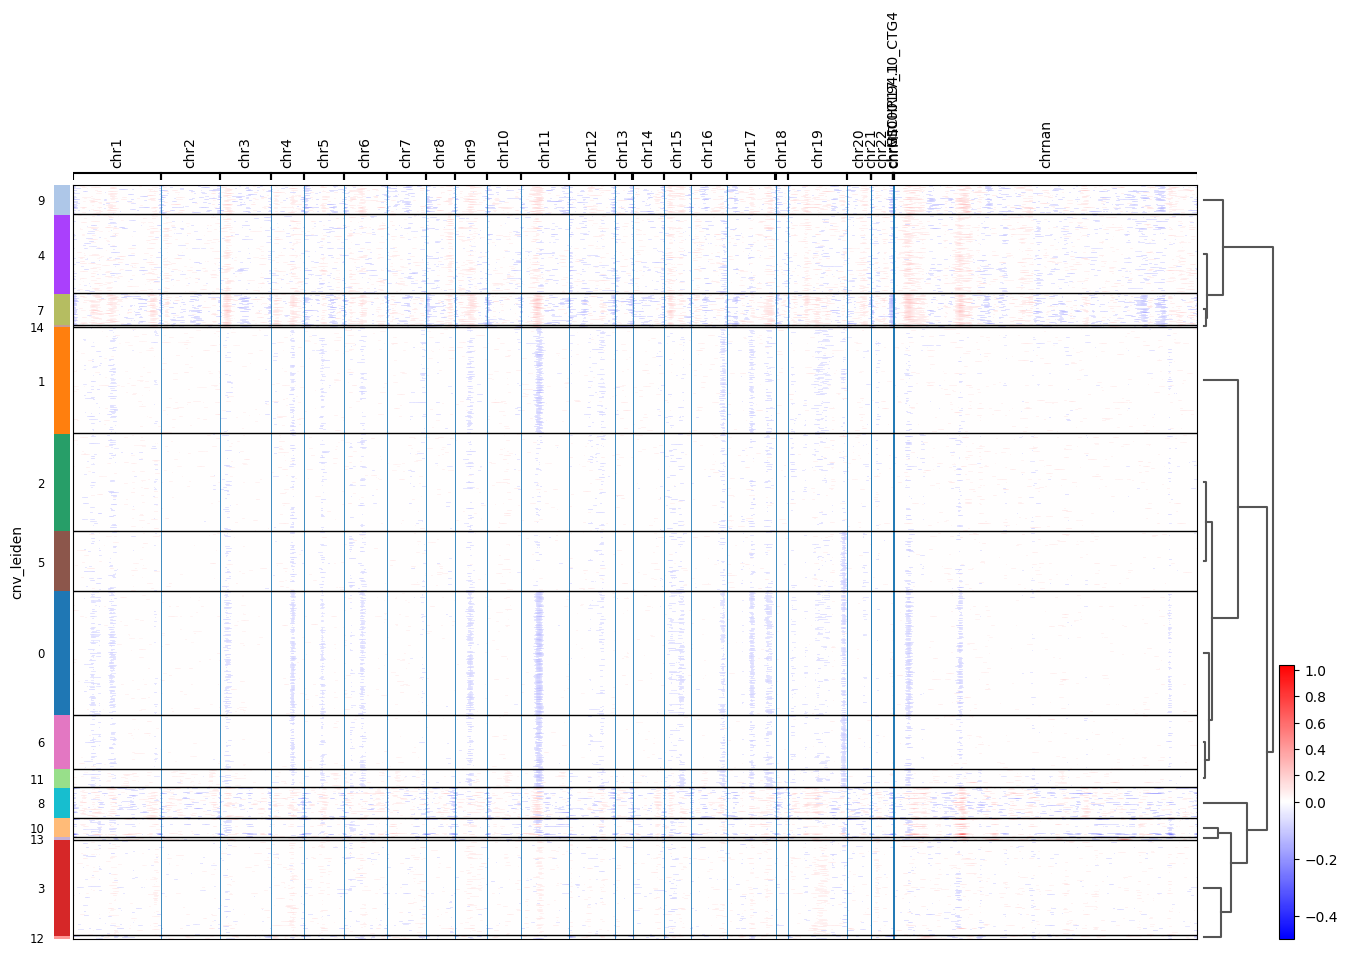

In [21]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Level_2_transfered_label' as categorical


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


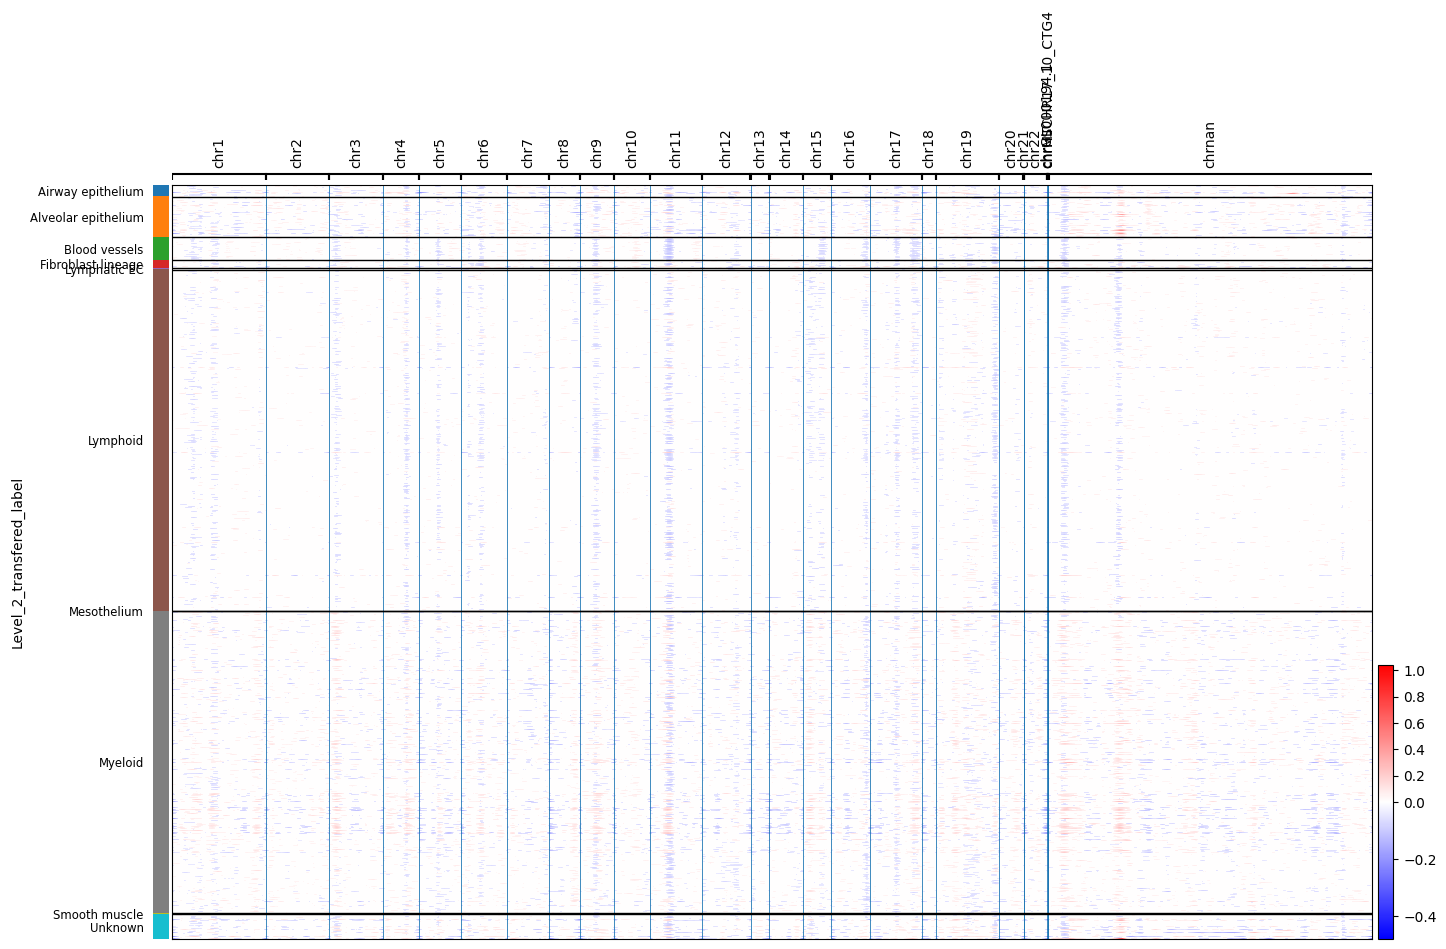

In [22]:
cnv.pl.chromosome_heatmap(adata, groupby="Level_2_transfered_label")

In [23]:
%%time
#papermill_description=CLUSTERING

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


CPU times: user 5min 55s, sys: 6min 5s, total: 12min 1s
Wall time: 1min 30s


In [24]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'Level_2_transfered_label' as categorical


... storing 'chromosome' as categorical


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

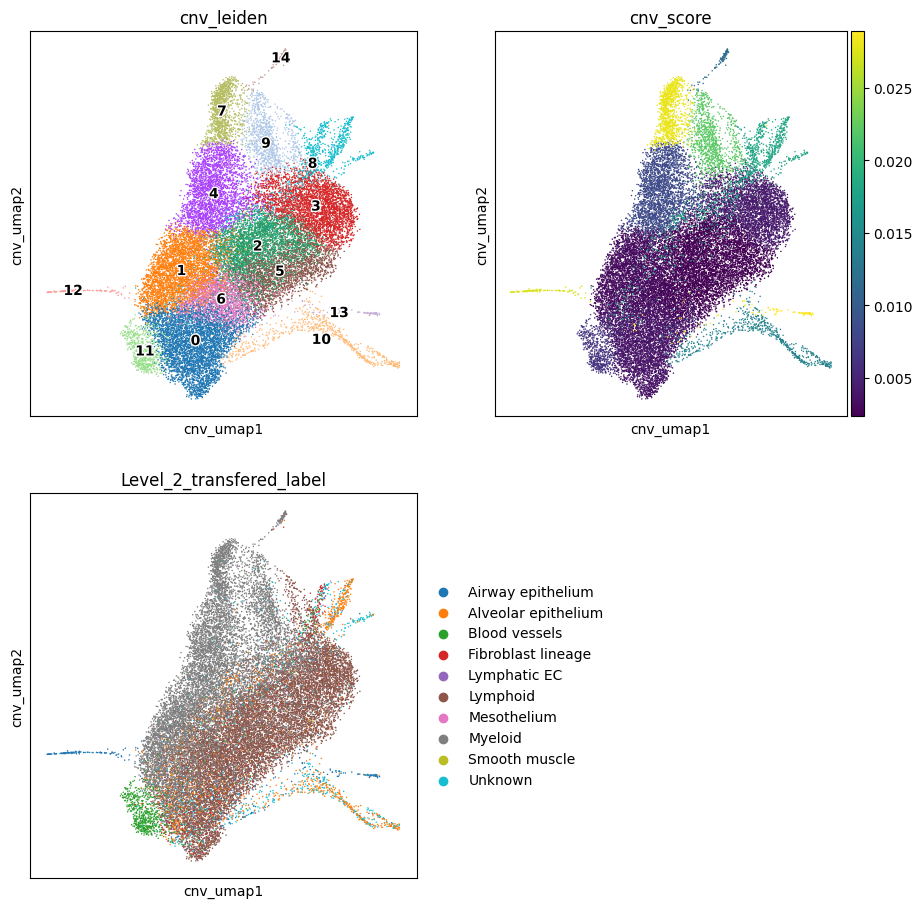

In [25]:
#papermill_description=PLOTS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="Level_2_transfered_label", ax=ax3)